# Dynex SDK - nBit Adder Native Gate Circuit Example

/usr/local/lib/python3.10/dist-packages/pennylane/__init__.py:184: PennyLaneDeprecationWarning: QubitDevice will no longer be accessible top level. Please access the class as pennylane.devices.QubitDevice
  warn(


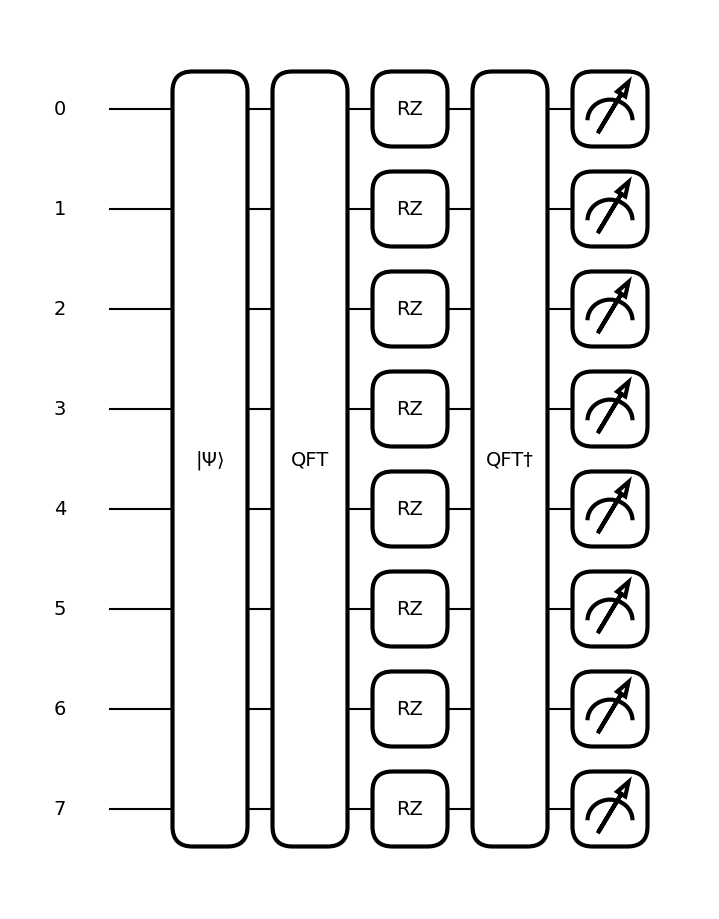

In [1]:
import pennylane as qml
import numpy as np
from pennylane_qiskit import AerDevice
from qiskit_ibm_runtime import QiskitRuntimeService

# Load IBMQ account and get the least busy QPU
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

# Parameters to add
params = [58, 142]

# Calculate the number of qubits
def Nqubits(a, b):
    mxVal = a + b
    return mxVal.bit_length()

wires = Nqubits(*params)

# Define the Kfourier function
def Kfourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

# FullAdder circuit
def FullAdder(params, state=False):  # Change to `state=False` to use sampling
    a, b = params
    wires = Nqubits(a, b)
    qml.BasisEmbedding(a, wires=range(wires))
    qml.QFT(wires=range(wires))
    Kfourier(b, range(wires))
    qml.adjoint(qml.QFT)(wires=range(wires))
    if state:
        return qml.state()  # This may not be supported on the Qiskit Aer device
    else:
        return qml.sample()  # Use sampling instead

# Set up the Qiskit IBMQ device
dev = qml.device("qiskit.ibmq", wires=wires, backend=backend)

# Run the circuit on the device
@qml.qnode(dev)
def circuit():
    return FullAdder(params)

# draw circuit:
_ = qml.draw_mpl(FullAdder, style="black_white")(params)

In [2]:
# Run the circuit and get the output (state or sample)
output = circuit()
print(output)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 ...
 [1 0 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [32]:
bitStr = ''.join(map(str, output[0].astype(int)))
dynexResult = int(bitStr, 2)
print("IBM Result:", dynexResult)
print("Expected Result:", sum(params))
isValidDynex = dynexResult == sum(params)
print("Is IBM Result Valid?", isValidDynex)

IBM Result: 136
Expected Result: 200
Is IBM Result Valid? False


In [34]:
# Mean sample:

Number of shots: 1024
Mean result: [0.48632812 0.50195312 0.48046875 0.49316406 0.48242188 0.47753906
 0.453125   0.50878906]
Mean result (bits): [0, 1, 0, 0, 0, 0, 0, 1]
IBM QPU Result: 65
Expected Result: 200 11001000
Is Dynex Result Valid? False


<BarContainer object of 8 artists>

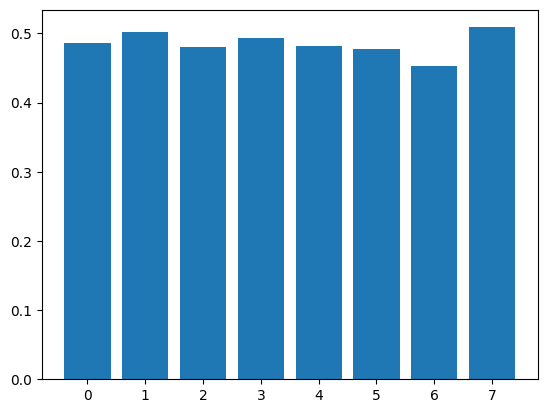

In [44]:
import matplotlib.pyplot as plt
means =  np.mean(np.array(output), axis=0)
means_bit = [1 if x > 0.5 else 0 for x in means]
print("Number of shots:",len(output))
print("Mean result:", means)
print("Mean result (bits):", means_bit)
bitStr = ''.join(map(str, means_bit))
dynexResult = int(bitStr, 2)
print("IBM QPU Result:", dynexResult)
print("Expected Result:", sum(params), bin(sum(params))[2:])
isValidDynex = dynexResult == sum(params)
print("Is Dynex Result Valid?", isValidDynex)
plt.bar(range(len(means)), means)